In [ ]:
import os
import sys

# change the directory to the root of the project
path = os.path.dirname(os.getcwd())
sys.path.append(path)

from PIL import Image
import torch
from models.models import BaselineModel, IngrPredModel, MultimodalPredictionNetwork
from torchvision import transforms
import pandas as pd
import numpy as np


In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#============== Load the model ==============#
embeddings = torch.load(f'../utils/data/ingredient_embeddings_gnn_gat.pt', map_location=device, weights_only=True)

model = MultimodalPredictionNetwork(num_ingr=199, backbone='resnet', ingredient_embedding=embeddings).to(device)
model.load_state_dict(torch.load("../models/checkpoints/multimodal_resnet_gat_pretrained_da_16_75_25.pth", map_location=device, weights_only=True))

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)

#============== Load the ingredient metadata ==============#
dataset_path = '../../data/nutrition5k_reconstructed/'

image_path = os.path.join(dataset_path, 'images')
ingr_mata = os.path.join(dataset_path, 'metadata/ingredients_metadata.csv')

# Load the ingredient metadata
ingr_dataset_path = '../utils/data/test_labels_ingr_log.csv'
ingr_df = pd.read_csv(ingr_mata)
ingr_index = {}
ingr_indx_df = pd.read_csv(ingr_dataset_path)
colnames = ingr_indx_df.columns[1:-1]
for i in range(len(colnames)):
    ingr_index[i] = colnames[i]

# ingr,id,cal/g,fat(g),carb(g),protein(g)
ingr_dict = {}
for i in range(len(ingr_df)):
    ingr = ingr_df.iloc[i]['ingr']
    cal = ingr_df.iloc[i]['cal/g']
    fat = ingr_df.iloc[i]['fat(g)']
    carb = ingr_df.iloc[i]['carb(g)']
    protein = ingr_df.iloc[i]['protein(g)']
    ingr_dict[ingr] = (cal, fat, carb, protein)

#============== Inference function ==============#
def calculate_ingrdients_and_nutritional_facts(outputs, ingr_dict, ingr_index, k = 3):
    # outputs will always be (1, 199) since we are processing one image at a time
    outputs = outputs.squeeze(0).cpu().detach().numpy()
    sample_calories = 0
    sample_mass = 0
    sample_fat = 0
    sample_carbs = 0
    sample_protein = 0
    top_k_ingr = []
    
    idx = np.where(outputs > 0.0)[0]
    if len(idx) != 0:
        # Dictionary to store ingredient mass for top k selection
        ingredient_masses = {}
        for ingr_idx in idx:
            mass = outputs[ingr_idx]
            # Convert back from log scale
            mass = np.exp(mass) - 1
            ingr_name = ingr_index[ingr_idx]
            cal, fat, carb, protein = ingr_dict[ingr_name]
            
            sample_calories += mass * cal
            sample_fat += mass * fat
            sample_carbs += mass * carb
            sample_protein += mass * protein
            sample_mass += mass
            
            # Store ingredient name and mass
            ingredient_masses[ingr_name] = mass
            
        # Sort ingredients by mass and select the top 3
        sorted_ingredients = sorted(ingredient_masses.items(), key=lambda x: x[1], reverse=True)
        top_k_ingr = [ingr for ingr, _ in sorted_ingredients[:k]]
    else:
        top_k_ingr = ["No ingredients detected"]
        
    return {
        "calories": sample_calories,
        "mass": sample_mass,
        "fat": sample_fat,
        "carbs": sample_carbs,
        "protein": sample_protein,
        "top_k_ingr": top_k_ingr
    }
    
#============== Process the image ==============#
# Function to process the image and predict
def process_image(image_file = None):

    # Preprocess the image
    image_tensor = preprocess_image(image_file)
    outputs = model(image_tensor)
    results = calculate_ingrdients_and_nutritional_facts(outputs, ingr_dict, ingr_index)
    ingredients = results["top_k_ingr"]
    nutritional_facts = {
        "Calories": results["calories"],
        "Total Mass (g)": results["mass"],
        "Fat (g)": results["fat"],
        "Carbs (g)": results["carbs"],
        "Protein (g)": results["protein"],
    }
    
    return ingredients, nutritional_facts

#============== Test ==============#
image_idx = os.listdir(image_path)

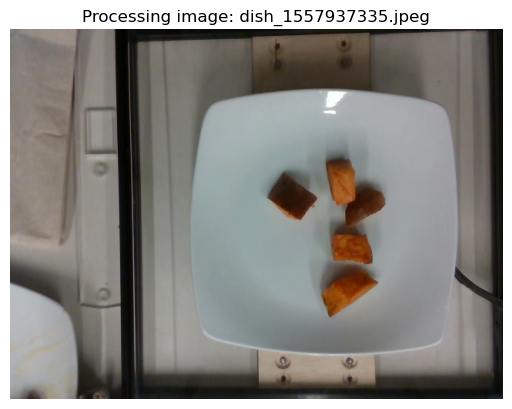

Top 3 ingredients: ['sweet potato', 'yam', 'carrot']
Calories: 95.55476456592085
Total Mass (g): 71.48850214481354
Fat (g): 4.631028084397318
Carbs (g): 10.554763615846628
Protein (g): 3.5282721286058436



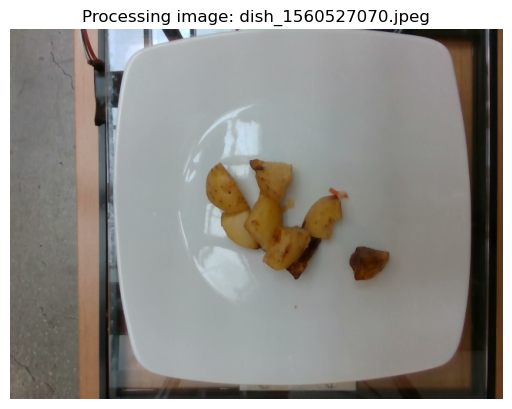

Top 3 ingredients: ['roasted potatoes', 'sweet potato', 'potatoes']
Calories: 78.91849439427853
Total Mass (g): 65.89776957035065
Fat (g): 3.136583923220635
Carbs (g): 9.698362828493114
Protein (g): 3.118357957029342



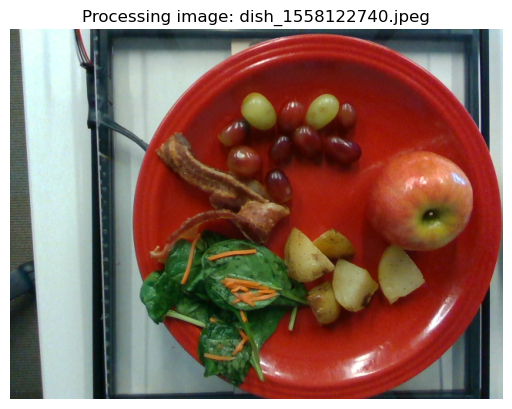

Top 3 ingredients: ['apple', 'mixed greens', 'deprecated']
Calories: 142.16305039215086
Total Mass (g): 155.12397003173828
Fat (g): 5.765105343818664
Carbs (g): 19.514186046838756
Protein (g): 4.977004173636436



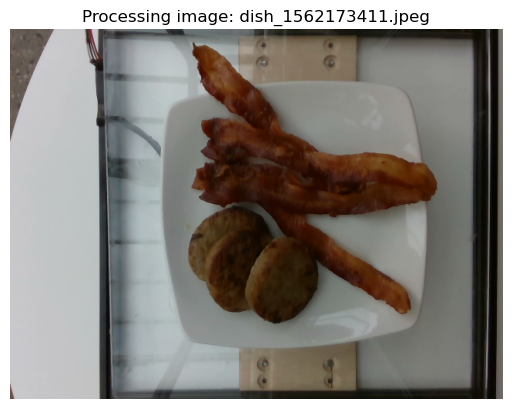

Top 3 ingredients: ['bacon', 'sausage', 'berries']
Calories: 396.6445380074739
Total Mass (g): 107.77689266204834
Fat (g): 29.262877055644996
Carbs (g): 7.2641554497480385
Protein (g): 25.25463342955112



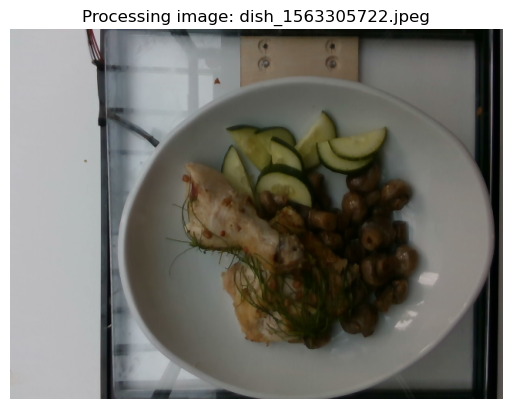

Top 3 ingredients: ['chicken', 'mushroom', 'cucumbers']
Calories: 154.63868310256015
Total Mass (g): 140.95626080036163
Fat (g): 6.564651875734328
Carbs (g): 8.794299501895908
Protein (g): 16.200364730405813



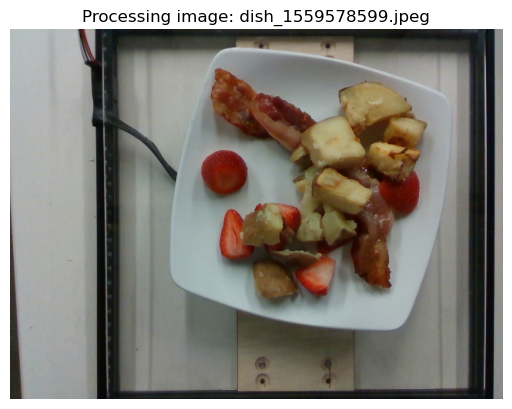

Top 3 ingredients: ['sweet potato', 'cherry tomatoes', 'carrot']
Calories: 132.45296249270442
Total Mass (g): 105.72067761421204
Fat (g): 6.194065608143806
Carbs (g): 14.531571910262102
Protein (g): 5.045142087578773



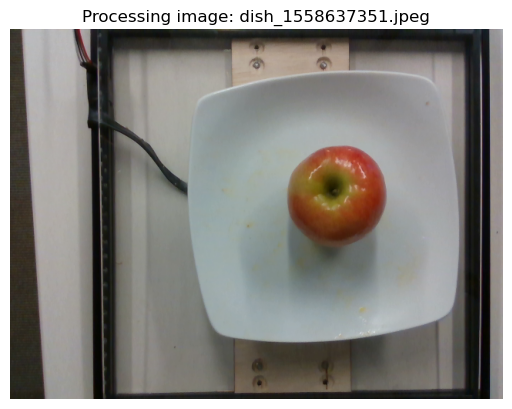

Top 3 ingredients: ['apple', 'deprecated', 'carrot']
Calories: 51.10417038543226
Total Mass (g): 69.93795156478882
Fat (g): 1.05037948179245
Carbs (g): 10.25188638174534
Protein (g): 1.2109135033369065



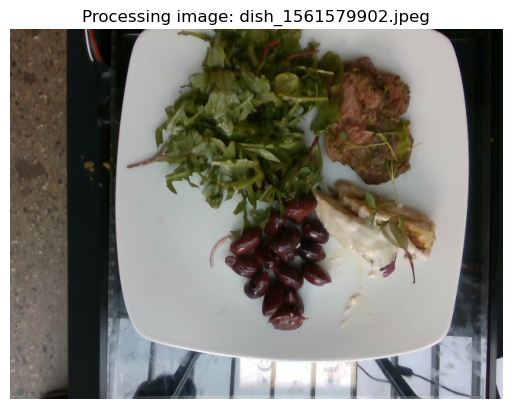

Top 3 ingredients: ['olives', 'chicken', 'arugula']
Calories: 196.4699314998388
Total Mass (g): 145.92805635929108
Fat (g): 11.742790283679968
Carbs (g): 11.022134478807454
Protein (g): 12.88425913572311



In [7]:
import random
import matplotlib.pyplot as plt
# randomly select 16 images
random.seed(247)

selected_images = random.sample(image_idx, 8)
k = 3
for image in selected_images:
    image_file = os.path.join(image_path, image)
    # Display the image
    img = Image.open(image_file)
    plt.imshow(img)
    plt.axis('off')  # Hide axes for clarity
    plt.title(f"Processing image: {image}")
    plt.show()
    
    ingredients, nutritional_facts = process_image(image_file)
    print(f'Top {k} ingredients: {ingredients}')
    for key, value in nutritional_facts.items():
        print(f"{key}: {value}")
    print()